# 文字分類(Text Classification)

In [6]:
import numpy as np

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds

import matplotlib.pyplot as plt

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

Version:  2.3.0
Eager mode:  True
Hub version:  0.9.0
GPU is available


## 下載影評資料集(IMDB)

In [7]:
train_data, test_data = tfds.load(name="imdb_reviews", split=["train", "test"], 
                                  batch_size=-1, as_supervised=True)

train_examples, train_labels = tfds.as_numpy(train_data)
test_examples, test_labels = tfds.as_numpy(test_data)

C:\Users\mikec\tensorflow_datasets\imdb_reviews\plain_text\0.1.0
Using C:\Users\mikec\tensorflow_datasets\imdb_reviews\plain_text\1.0.0 instead.


Shuffling and writing examples to C:\Users\mikec\tensorflow_datasets\imdb_reviews\plain_text\1.0.0.incompleteYRSZR9\imdb_reviews-train.tfrecord


Shuffling and writing examples to C:\Users\mikec\tensorflow_datasets\imdb_reviews\plain_text\1.0.0.incompleteYRSZR9\imdb_reviews-test.tfrecord


Shuffling and writing examples to C:\Users\mikec\tensorflow_datasets\imdb_reviews\plain_text\1.0.0.incompleteYRSZR9\imdb_reviews-unsupervised.tfrecord


Dataset imdb_reviews downloaded and prepared to C:\Users\mikec\tensorflow_datasets\imdb_reviews\plain_text\1.0.0. Subsequent calls will reuse this data.


In [8]:
print("Training entries: {}, test entries: {}".format(len(train_examples), len(test_examples)))

Training entries: 25000, test entries: 25000


## 下載 Hub 的模型 gnews-swivel-20dim

In [9]:
# gnews-swivel-20dim：Token based text embedding trained on English Google News 130GB corpus
model = "https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim/1"
hub_layer = hub.KerasLayer(model, output_shape=[20], input_shape=[], 
                           dtype=tf.string, trainable=True)
hub_layer(train_examples[:3])

<tf.Tensor: shape=(3, 20), dtype=float32, numpy=
array([[ 1.765786  , -3.882232  ,  3.9134233 , -1.5557289 , -3.3362343 ,
        -1.7357955 , -1.9954445 ,  1.2989551 ,  5.081598  , -1.1041286 ,
        -2.0503852 , -0.72675157, -0.65675956,  0.24436149, -3.7208383 ,
         2.0954835 ,  2.2969332 , -2.0689783 , -2.9489717 , -1.1315987 ],
       [ 1.8804485 , -2.5852382 ,  3.4066997 ,  1.0982676 , -4.056685  ,
        -4.891284  , -2.785554  ,  1.3874227 ,  3.8476458 , -0.9256538 ,
        -1.896706  ,  1.2113281 ,  0.11474707,  0.76209456, -4.8791065 ,
         2.906149  ,  4.7087674 , -2.3652055 , -3.5015898 , -1.6390051 ],
       [ 0.71152234, -0.6353217 ,  1.7385626 , -1.1168286 , -0.5451594 ,
        -1.1808156 ,  0.09504455,  1.4653089 ,  0.66059524,  0.79308075,
        -2.2268345 ,  0.07446612, -1.4075904 , -0.70645386, -1.907037  ,
         1.4419787 ,  1.9551861 , -0.42660055, -2.8022065 ,  0.43727064]],
      dtype=float32)>

## 建立模型，Hub 模型後面接完全連接層(Dense) 

In [10]:
model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(1))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 20)                400020    
_________________________________________________________________
dense (Dense)                (None, 16)                336       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 400,373
Trainable params: 400,373
Non-trainable params: 0
_________________________________________________________________


In [11]:
model.compile(optimizer='adam',
              loss=tf.losses.BinaryCrossentropy(from_logits=True),
              metrics=[tf.metrics.BinaryAccuracy(threshold=0.0, name='accuracy')])

## 建立訓練資料及驗證資料

In [12]:
x_val = train_examples[:10000]
partial_x_train = train_examples[10000:]

y_val = train_labels[:10000]
partial_y_train = train_labels[10000:]

## 訓練模型

In [13]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=40,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/40
30/30 [==============================] - 2s 55ms/step - loss: 2.3770 - accuracy: 0.5055 - val_loss: 1.1486 - val_accuracy: 0.5357
Epoch 2/40
30/30 [==============================] - 1s 50ms/step - loss: 0.8176 - accuracy: 0.5667 - val_loss: 0.7419 - val_accuracy: 0.5678
Epoch 3/40
30/30 [==============================] - 1s 49ms/step - loss: 0.7100 - accuracy: 0.5939 - val_loss: 0.6924 - val_accuracy: 0.6033
Epoch 4/40
30/30 [==============================] - 1s 49ms/step - loss: 0.6670 - accuracy: 0.6191 - val_loss: 0.6589 - val_accuracy: 0.6280
Epoch 5/40
30/30 [==============================] - 1s 50ms/step - loss: 0.6309 - accuracy: 0.6498 - val_loss: 0.6266 - val_accuracy: 0.6565
Epoch 6/40
30/30 [==============================] - 1s 50ms/step - loss: 0.5941 - accuracy: 0.6861 - val_loss: 0.5924 - val_accuracy: 0.6870
Epoch 7/40
30/30 [==============================] - 1s 49ms/step - loss: 0.5543 - accuracy: 0.7237 - val_loss: 0.5569 - val_accuracy: 0.7216
Epoch 8/40
30

## 模型評估

In [14]:
results = model.evaluate(test_data, test_labels)

print(results)

782/782 [==============================] - 3s 4ms/step - loss: 0.3523 - accuracy: 0.8630
[0.3523283302783966, 0.8629599809646606]


## 繪製訓練過程的損失

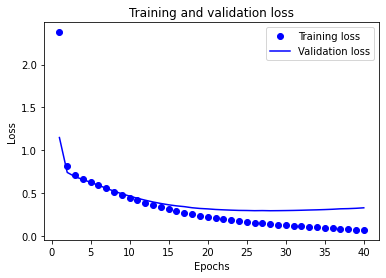

In [16]:
history_dict = history.history
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

## 繪製訓練過程的準確率

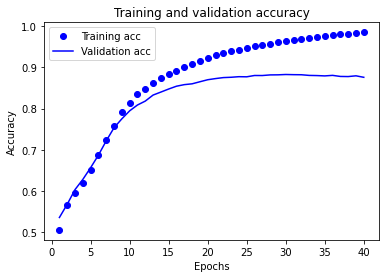

In [17]:
plt.clf()   # clear figure

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## 預測10筆資料

In [34]:
samples = test_examples[-10:]
pred = model.predict_classes([samples])
print(f'預測,  實際 : {str(x)[:100]}')
for y_pred, y, x in zip(pred, train_labels[-10:], samples):
    print(f'{y_pred[0]}   , {y}    : {str(x)[:100]}')


預測,  實際 : b"They just don't make cartoons like they used to. This one had wit, great characters, and the great
1   , 0    : b"Lots of scenes and dialogue are flat-out goofy, but when you add it all up, i.e. Machine's daily c
0   , 1    : b"This movie started out as a quite decent-looking film but it never really kicked off, instead it b
1   , 1    : b"NBC was putting out a lot of good product when this series came out, but none of it was getting vi
1   , 0    : b"I've felt that Rupert Grint has a lot of promise from that role by which everyone knows him. So ev
1   , 0    : b"I think the problem with this show not getting the respect it truly deserves is that it comes afte
0   , 0    : b"Feeling Minnesota is not really a road movie, but that's still the best categorization I can gener
1   , 1    : b'This is, without doubt, one of my favourite horror films ever! I really cannot believe that it did
0   , 0    : b"Most predicable movie I've ever seen...extremely boring, I feel like I've se